In [42]:
import pandas as pd
import json
from scipy.stats import chi2_contingency
import itertools
import datetime
from sklearn.preprocessing import FunctionTransformer
import numpy as np
import matplotlib.pyplot as plt

Visualizing the correlations between features and target

In [8]:
campaign = pd.read_json('campaign_impressions.json', lines=True, orient='columns')

In [9]:
segments = pd.read_csv('user_segments.csv')

In [10]:
segments.rename(columns = {'Unnamed: 0':'uuid'}, inplace = True)

In [11]:
for i in ['resp', 'dev']:
    column_unnested = pd.json_normalize(campaign[i])
    column_unnested = column_unnested.add_prefix(i+'_')
    campaign = campaign.drop([i], axis = 1)
    campaign = pd.concat([campaign, column_unnested], axis=1)

## merge

In [12]:
campaign_enriched = pd.merge(campaign,segments,how='right',
                             
                             left_on=['uuid'],right_on=['uuid'])

## count na

In [15]:
campaign_enriched.isna().sum()

ts                 0
uuid               0
conv               0
resp_oi            0
resp_cr          529
resp_c             0
dev_os             0
dev_sid            0
dev_app            0
ANIMAL             0
CAR_OWNER          0
GARDEN             0
OFFICE_WORKER      0
PARENT             0
dtype: int64

## transform time stamp

In [16]:
campaign_enriched["ts"] = pd.to_datetime(campaign_enriched.ts, unit='s')

In [17]:
campaign_enriched["ts"]

0      2017-12-01 03:47:13
1      2017-12-01 12:11:19
2      2017-12-01 13:24:49
3      2017-12-01 07:57:37
4      2017-12-01 15:23:44
               ...        
9995   2017-12-01 06:12:55
9996   2017-12-01 19:30:11
9997   2017-12-01 20:20:18
9998   2017-12-01 12:58:56
9999   2017-12-01 14:55:14
Name: ts, Length: 10000, dtype: datetime64[ns]

In [46]:
campaign_enriched['year'] = campaign_enriched.ts.dt.year     
campaign_enriched['month'] = campaign_enriched.ts.dt.month   
campaign_enriched['day'] = campaign_enriched.ts.dt.day   
campaign_enriched['hour'] = campaign_enriched.ts.dt.hour.apply(pd.to_numeric) 

In [47]:
campaign_enriched["hour_sin"] = campaign_enriched['hour'].apply(lambda x: np.sin(x / 24 * 2 * np.pi))
campaign_enriched["hour_cos"] = campaign_enriched['hour'].apply(lambda x: np.cos(x / 24 * 2 * np.pi))

## numerics

In [156]:
campaign_enriched['hour'].describe()

count    10000.000000
mean        11.433700
std          6.917701
min          0.000000
25%          5.000000
50%         11.000000
75%         17.000000
max         23.000000
Name: hour, dtype: float64

In [151]:
print(campaign_enriched['hour'].astype(float).skew())
print(campaign_enriched['hour'].astype(float).kurt())

0.017933349783505918
-1.191534655710618


In [48]:
campaign_enriched['hour_sin'].describe()

count    1.000000e+04
mean     8.948048e-03
std      7.023175e-01
min     -1.000000e+00
25%     -7.071068e-01
50%      1.224647e-16
75%      7.071068e-01
max      1.000000e+00
Name: hour_sin, dtype: float64

In [49]:
print(campaign_enriched['hour_sin'].astype(float).skew())
print(campaign_enriched['hour_sin'].astype(float).kurt())

-0.018547469992270128
-1.4814214431678605


In [50]:
campaign_enriched['hour_cos'].describe()

count    1.000000e+04
mean    -3.028216e-03
std      7.118714e-01
min     -1.000000e+00
25%     -7.071068e-01
50%      6.123234e-17
75%      7.071068e-01
max      1.000000e+00
Name: hour_cos, dtype: float64

In [51]:
print(campaign_enriched['hour_cos'].astype(float).skew())
print(campaign_enriched['hour_cos'].astype(float).kurt())

-0.0003430040417276148
-1.5090845644442739


<AxesSubplot:ylabel='Density'>

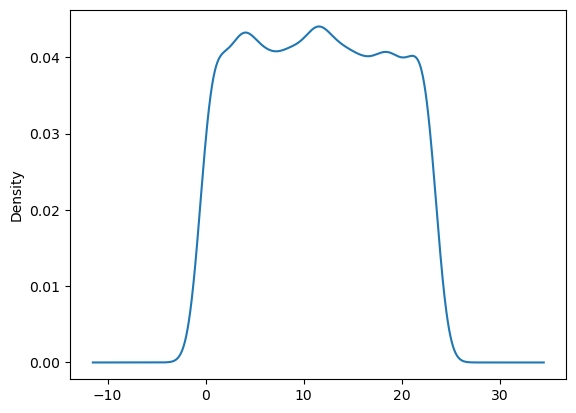

In [56]:
campaign_enriched['hour'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

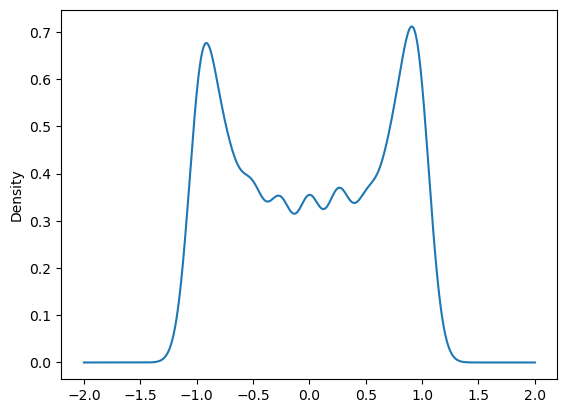

In [57]:
campaign_enriched['hour_sin'].plot(kind='kde')

<AxesSubplot:ylabel='Density'>

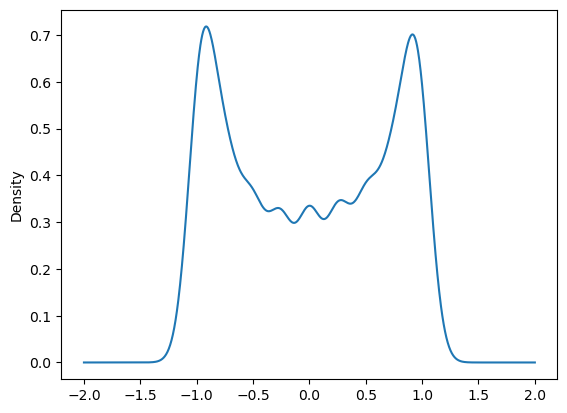

In [58]:
campaign_enriched['hour_cos'].plot(kind='kde')

## plot categoricals

<AxesSubplot:>

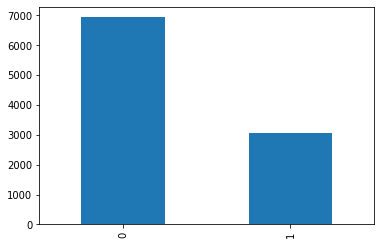

In [48]:
campaign_enriched['conv'].value_counts().plot.bar()

<AxesSubplot:>

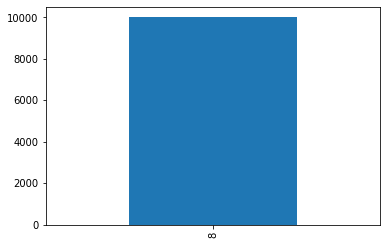

In [49]:
campaign_enriched['resp_oi'].value_counts().plot.bar()

<AxesSubplot:>

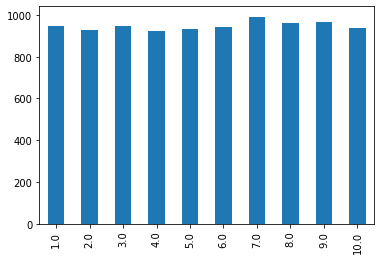

In [50]:
campaign_enriched['resp_cr'].value_counts().plot.bar()

<AxesSubplot:>

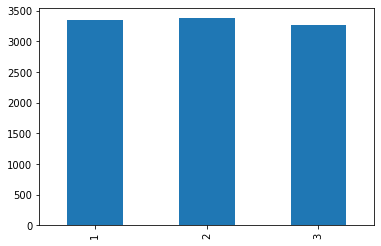

In [51]:
campaign_enriched['resp_c'].value_counts().plot.bar()

<AxesSubplot:>

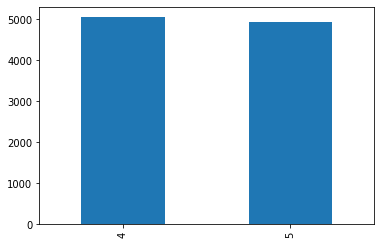

In [52]:
campaign_enriched['dev_os'].value_counts().plot.bar()

<AxesSubplot:>

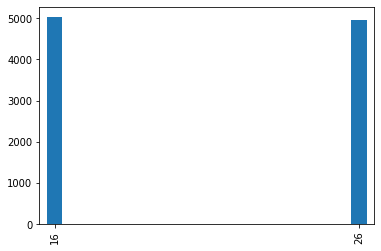

In [53]:
campaign_enriched['dev_sid'].value_counts().plot.bar()

<AxesSubplot:>

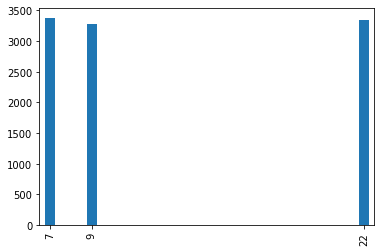

In [54]:
campaign_enriched['dev_app'].value_counts().plot.bar()

<AxesSubplot:>

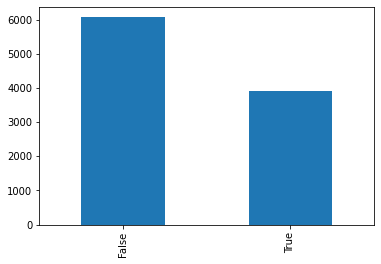

In [55]:
campaign_enriched['ANIMAL'].value_counts().plot.bar()

<AxesSubplot:>

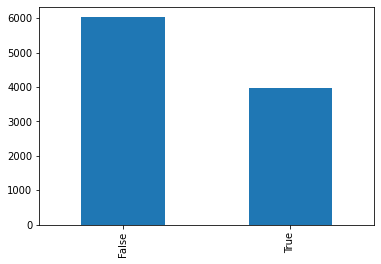

In [56]:
campaign_enriched['CAR_OWNER'].value_counts().plot.bar()

<AxesSubplot:>

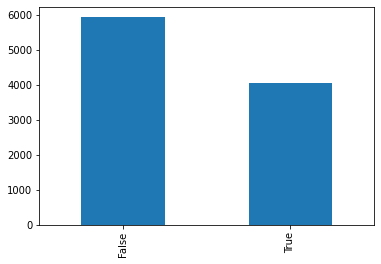

In [57]:
campaign_enriched['GARDEN'].value_counts().plot.bar()

<AxesSubplot:>

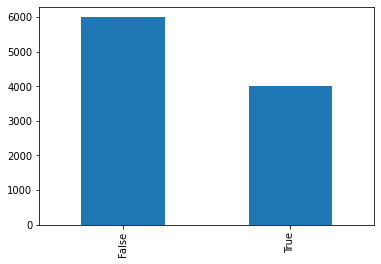

In [58]:
campaign_enriched['OFFICE_WORKER'].value_counts().plot.bar()

<AxesSubplot:>

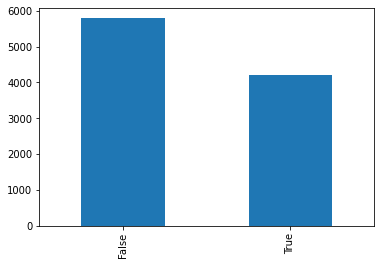

In [59]:
campaign_enriched['PARENT'].value_counts().plot.bar()

## chi 2

In [90]:
cols_chi2 = ['resp_oi', 'resp_cr', 'resp_c', 'dev_os','dev_sid', 'dev_app','nb_of_id_campaign', 
            'ANIMAL', 'CAR_OWNER','GARDEN','OFFICE_WORKER','PARENT']

tuples_columns = []

for cols_chi2 in itertools.combinations(cols_chi2,2):
    tuples_columns.append(cols_chi2)

tuples_columns = list(set(tuples_columns))

In [112]:
#stocker i0 et i1
dependent_col = []
for i in tuples_columns:
    
    if i[0] != i[1]:
        
        #step 1: Extract required columns, ideally it should be two columns at a time
        data_interim=campaign_enriched[[i[0], i[1]]]

        #step 2: Create a cross tab which is a contigency table
        data_cont=pd.crosstab(data_interim[i[0]], data_interim[i[1]])

        stat, p, dof, expected = chi2_contingency(data_cont)

        #interpret p-value
        alpha = 0.05

        if p <= alpha:
            print('{col1} and {col2} are dependent (reject H0)'.format(col1 = i[0], col2 = i[1]))
            dependent_col.append(i[0])
            dependent_col.append(i[1])
        else:
            pass


nb_of_id_campaign and CAR_OWNER are dependent (reject H0)
dev_app and ANIMAL are dependent (reject H0)
ANIMAL and CAR_OWNER are dependent (reject H0)
ANIMAL and GARDEN are dependent (reject H0)
GARDEN and PARENT are dependent (reject H0)
nb_of_id_campaign and GARDEN are dependent (reject H0)
GARDEN and OFFICE_WORKER are dependent (reject H0)
CAR_OWNER and PARENT are dependent (reject H0)
ANIMAL and PARENT are dependent (reject H0)
ANIMAL and OFFICE_WORKER are dependent (reject H0)
nb_of_id_campaign and PARENT are dependent (reject H0)
nb_of_id_campaign and OFFICE_WORKER are dependent (reject H0)
CAR_OWNER and GARDEN are dependent (reject H0)
resp_cr and resp_c are dependent (reject H0)
nb_of_id_campaign and ANIMAL are dependent (reject H0)
CAR_OWNER and OFFICE_WORKER are dependent (reject H0)


In [113]:
set(dependent_col)

{'ANIMAL',
 'CAR_OWNER',
 'GARDEN',
 'OFFICE_WORKER',
 'PARENT',
 'dev_app',
 'nb_of_id_campaign',
 'resp_c',
 'resp_cr'}

In [152]:
# cols to keep

# resp_c, uuid, hour, conv, dev_app, dev_sid, dev_os, OFFICE_WORKER, PARENT

## correlation

In [55]:
campaign_enriched[['hour_sin', 'hour_cos']].corr()

,hour_sin,hour_cos
hour_sin,1.000000,0.002104
hour_cos,0.002104,1.000000
